In [5]:

# 参数设置
gammas = ["050", "060", "070","080"]  # 不同的 gamma 值
target = "Pb208"
bmin, bmax = 1, 10  # b 的范围
px_diff_data = {gamma: [] for gamma in gammas}  # 存储不同 gamma 下的 P_x^p - P_x^n 数据
# for gamma in gammas:
#     pols = ["znp", "zpn"]
#     for b in range(bmin, bmax + 1):
#         for p in pols:
#             folder = os.path.join(smdir, f"data/qmdrawdata/qmdrawdata/z_pol/b_discrete/d+{target}E190g{gamma}{p}/")
#             filename = f"dbreakb{b:02d}.dat"
#             filepath = os.path.join(folder, filename)

#             # 检查文件是否存在
#             if not os.path.isfile(filepath):
#                 print(f"Error: File {filepath} not found.")
#                 continue

#             # 读取文件并解析数据
#             with open(filepath, "r") as inputfile:
#                 info = inputfile.readline()
#                 header = inputfile.readline()
#                 for line in inputfile:
#                     data = line.split()
#                     if len(data) < 7:
#                         continue
#                     eventNo = int(data[0])
#                     pxp, pyp, pzp = map(float, data[1:4])
#                     pxn, pyn, pzn = map(float, data[4:7])

#                     # 筛选条件
#                     if eventNo < 10000.0 * b / bmax:
#                         pp = np.array([pxp, pyp, pzp])
#                         pn = np.array([pxn, pyn, pzn])
#                         phi = np.arctan2((pp + pn)[1], (pp + pn)[0])

#                         # 旋转坐标系
#                         rotation_matrix = np.array([
#                             [np.cos(-phi), -np.sin(-phi), 0],
#                             [np.sin(-phi), np.cos(-phi), 0],
#                             [0, 0, 1]
#                         ])
#                         pp = rotation_matrix @ pp
#                         pn = rotation_matrix @ pn

#                         pxp, pyp, pzp = pp
#                         pxn, pyn, pzn = pn

#                         # 筛选条件
#                         if (
#                             pzp + pzn > 1150 and
#                             (np.pi - abs(phi)) < 0.5 and
#                             abs(pzp - pzn) < 150 and
#                             pxp + pxn < 200 and
#                             np.sqrt((pxn + pxp)**2 + (pyn + pyp)**2) > 50
#                         ):
#                             px_diff_data[gamma].append(pxp - pxn)



画出Pz 横坐标 ， Px 纵坐标的 二维直方图。 

## 统一的数据收集函数 - 避免重复代码

优化前的问题：
- Cell 4 和 Cell 8 收集 Y极化数据（重复）
- Cell 5 和 Cell 9 收集 Z极化数据（重复）

现在用函数统一处理：

In [6]:
def collect_y_polarization_data(gammas, pols, target, smdir):
    """
    收集 Y极化数据的统一函数
    
    参数:
        gammas: gamma值列表，如 ["050", "060", "070", "080"]
        pols: 极化类型列表，如 ["ynp", "ypn"]
        target: 靶核，如 "Pb208"
        smdir: 数据根目录
    
    返回:
        字典结构: {gamma: {'proton': {'px':[], 'py':[], 'pz':[]}, 'neutron': {...}}}
    """
    data = {
        gamma: {
            'proton': {'px': [], 'py': [], 'pz': []},
            'neutron': {'px': [], 'py': [], 'pz': []}
        } for gamma in gammas
    }
    
    for gamma in gammas:
        for p in pols:
            folder = os.path.join(smdir, f"data/qmdrawdata/qmdrawdata/y_pol/phi_random/d+{target}E190g{gamma}{p}/")
            filepath = os.path.join(folder, "dbreak.dat")

            if not os.path.isfile(filepath):
                print(f"⚠️  跳过: {filepath}")
                continue

            with open(filepath, 'r') as inputfile:
                # 跳过文件头
                inputfile.readline()
                inputfile.readline()

                for line in inputfile:
                    data_line = line.split()
                    if len(data_line) < 7:
                        continue
                    
                    # 解析原始动量
                    pxp_orig, pyp_orig, pzp_orig = map(float, data_line[1:4])
                    pxn_orig, pyn_orig, pzn_orig = map(float, data_line[4:7])

                    pp_orig = np.array([pxp_orig, pyp_orig, pzp_orig])
                    pn_orig = np.array([pxn_orig, pyn_orig, pzn_orig])
                    
                    vec_sum_orig = pp_orig + pn_orig
                    phi_for_rotation = np.arctan2(vec_sum_orig[1], vec_sum_orig[0])

                    # 筛选条件1：基本动量条件
                    if not (abs(pyp_orig - pyn_orig) < 150 and 
                           (vec_sum_orig[0]**2 + vec_sum_orig[1]**2) > 2500):
                        continue
                    
                    # 旋转到反应平面
                    cos_phi = np.cos(-phi_for_rotation)
                    sin_phi = np.sin(-phi_for_rotation)
                    R_z = np.array([
                        [cos_phi, -sin_phi, 0],
                        [sin_phi,  cos_phi, 0],
                        [0,        0,       1]
                    ])

                    pp_rotated = R_z @ pp_orig
                    pn_rotated = R_z @ pn_orig

                    # 筛选条件2：旋转后的条件
                    if not ((pp_rotated[0] + pn_rotated[0]) < 200 and 
                           (np.pi - abs(phi_for_rotation)) < 0.2):
                        continue
                    
                    # 存储数据
                    data[gamma]['proton']['px'].append(pp_rotated[0])
                    data[gamma]['proton']['py'].append(pp_rotated[1])
                    data[gamma]['proton']['pz'].append(pp_rotated[2])
                    
                    data[gamma]['neutron']['px'].append(pn_rotated[0])
                    data[gamma]['neutron']['py'].append(pn_rotated[1])
                    data[gamma]['neutron']['pz'].append(pn_rotated[2])
    
    return data


def collect_z_polarization_data(gammas, pols_z, target, smdir, bmin=1, bmax=10):
    """
    收集 Z极化数据的统一函数
    
    参数:
        gammas: gamma值列表
        pols_z: Z极化类型列表，如 ["znp", "zpn"]
        target: 靶核
        smdir: 数据根目录
        bmin, bmax: 碰撞参数范围
    
    返回:
        字典结构: {gamma: {'proton': {'px':[], 'py':[], 'pz':[]}, 'neutron': {...}}}
    """
    data = {
        gamma: {
            'proton': {'px': [], 'py': [], 'pz': []},
            'neutron': {'px': [], 'py': [], 'pz': []}
        } for gamma in gammas
    }
    
    for gamma in gammas:
        for b in range(bmin, bmax + 1):
            for p in pols_z:
                folder = os.path.join(smdir, f"data/qmdrawdata/qmdrawdata/z_pol/b_discrete/d+{target}E190g{gamma}{p}/")
                filepath = os.path.join(folder, f"dbreakb{b:02d}.dat")

                if not os.path.isfile(filepath):
                    print(f"⚠️  跳过: {filepath}")
                    continue

                with open(filepath, "r") as inputfile:
                    # 跳过文件头
                    inputfile.readline()
                    inputfile.readline()
                    
                    for line in inputfile:
                        data_line = line.split()
                        if len(data_line) < 7:
                            continue
                        
                        eventNo = int(data_line[0])
                        
                        # 事件号筛选
                        if eventNo >= 10000.0 * b / bmax:
                            continue
                        
                        # 解析动量
                        pxp, pyp, pzp = map(float, data_line[1:4])
                        pxn, pyn, pzn = map(float, data_line[4:7])

                        pp = np.array([pxp, pyp, pzp])
                        pn = np.array([pxn, pyn, pzn])
                        phi = np.arctan2((pp + pn)[1], (pp + pn)[0])

                        # 旋转到反应平面
                        cos_phi = np.cos(-phi)
                        sin_phi = np.sin(-phi)
                        rotation_matrix = np.array([
                            [cos_phi, -sin_phi, 0],
                            [sin_phi,  cos_phi, 0],
                            [0,        0,       1]
                        ])
                        pp = rotation_matrix @ pp
                        pn = rotation_matrix @ pn

                        # 综合筛选条件
                        if not (pp[2] + pn[2] > 1150 and
                               (np.pi - abs(phi)) < 0.5 and
                               abs(pp[2] - pn[2]) < 150 and
                               pp[0] + pn[0] < 200 and
                               np.sqrt((pn[0] + pp[0])**2 + (pn[1] + pp[1])**2) > 50):
                            continue
                        
                        # 存储数据
                        data[gamma]['proton']['px'].append(pp[0])
                        data[gamma]['proton']['py'].append(pp[1])
                        data[gamma]['proton']['pz'].append(pp[2])
                        
                        data[gamma]['neutron']['px'].append(pn[0])
                        data[gamma]['neutron']['py'].append(pn[1])
                        data[gamma]['neutron']['pz'].append(pn[2])
    
    return data


# 现在只需调用函数即可，无需重复代码
print("=" * 60)
print("开始收集数据...")
print("=" * 60)

# 收集 Y极化数据
y_pol_data = collect_y_polarization_data(gammas, pols, target, smdir)
print("\n✅ Y极化数据收集完成：")
for gamma in gammas:
    n_events = len(y_pol_data[gamma]['proton']['px'])
    print(f"   γ={gamma}: {n_events:5d} 事件")

# 收集 Z极化数据
pols_z = ["znp", "zpn"]
z_pol_data = collect_z_polarization_data(gammas, pols_z, target, smdir, bmin=1, bmax=10)
print("\n✅ Z极化数据收集完成：")
for gamma in gammas:
    n_events = len(z_pol_data[gamma]['proton']['px'])
    print(f"   γ={gamma}: {n_events:5d} 事件")

print("\n" + "=" * 60)
print("数据收集完成！")
print("=" * 60)

开始收集数据...

✅ Y极化数据收集完成：
   γ=050: 13047 事件
   γ=060: 13905 事件
   γ=070: 14262 事件
   γ=080: 15566 事件

✅ Z极化数据收集完成：
   γ=050:  9178 事件
   γ=060:  6696 事件
   γ=070:  9619 事件
   γ=080: 12172 事件

数据收集完成！


## 绘制 Pz vs P⊥ 二维直方图

P⊥ = √(Px² + Py²) 是垂直于束流方向的横向动量

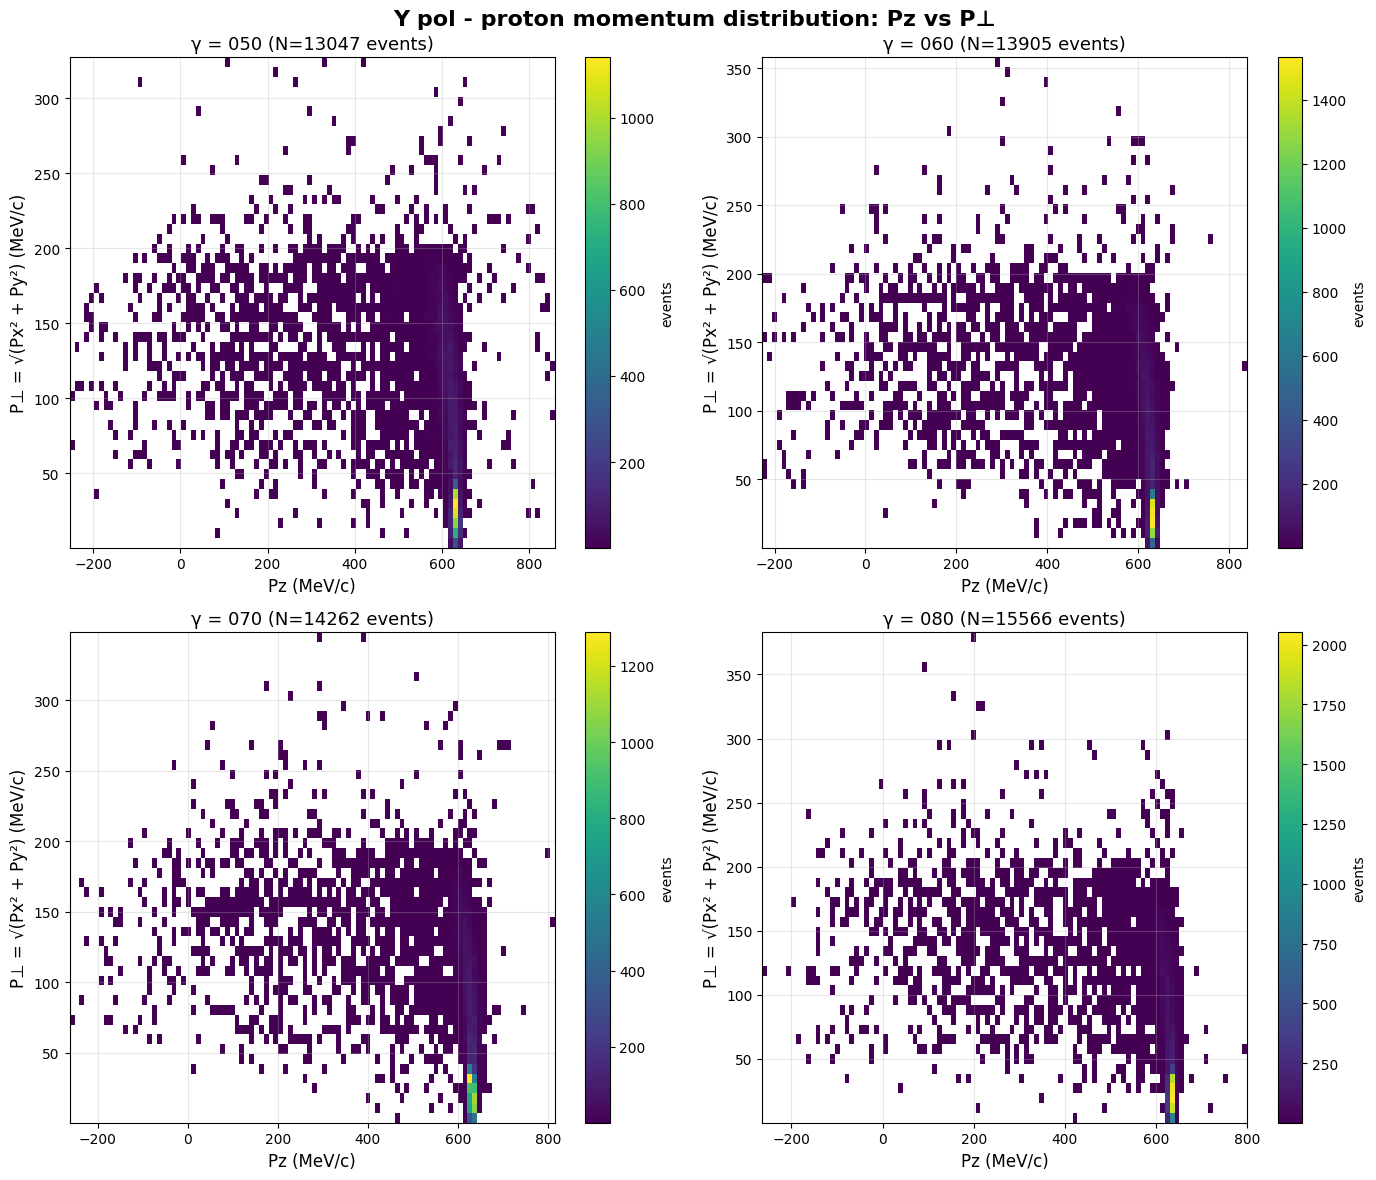


γ=050:
  Pz: mean=586.7, std=124.6, range=[-254.1, 859.1]
  P⊥: mean=69.0, std=56.6, range=[0.2, 327.3]

γ=060:
  Pz: mean=596.4, std=111.4, range=[-227.6, 840.9]
  P⊥: mean=60.3, std=53.6, range=[0.1, 357.9]

γ=070:
  Pz: mean=602.1, std=105.3, range=[-262.3, 815.2]
  P⊥: mean=53.4, std=50.8, range=[0.2, 348.4]

γ=080:
  Pz: mean=604.7, std=103.1, range=[-264.4, 800.4]
  P⊥: mean=49.2, std=48.7, range=[0.3, 382.9]


In [21]:
# Y极化数据：质子的 Pz vs P⊥ 二维直方图
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Y pol - proton momentum distribution: Pz vs P⊥', fontsize=16, fontweight='bold')

for idx, gamma in enumerate(gammas):
    ax = axes[idx // 2, idx % 2]
    
    # 计算 P⊥
    px = np.array(y_pol_data[gamma]['proton']['px'])
    py = np.array(y_pol_data[gamma]['proton']['py'])
    pz = np.array(y_pol_data[gamma]['proton']['pz'])
    p_perp = np.sqrt(px**2 + py**2)
    
    # 绘制二维直方图
    h = ax.hist2d(pz, p_perp, bins=[100, 50], cmap='viridis', cmin=1)
    plt.colorbar(h[3], ax=ax, label='events')
    
    ax.set_xlabel('Pz (MeV/c)', fontsize=12)
    ax.set_ylabel('P⊥ = √(Px² + Py²) (MeV/c)', fontsize=12)
    ax.set_title(f'γ = {gamma} (N={len(pz)} events)', fontsize=13)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for gamma in gammas:
    pz = np.array(y_pol_data[gamma]['proton']['pz'])
    px = np.array(y_pol_data[gamma]['proton']['px'])
    py = np.array(y_pol_data[gamma]['proton']['py'])
    p_perp = np.sqrt(px**2 + py**2)
    
    print(f"\nγ={gamma}:")
    print(f"  Pz: mean={np.mean(pz):.1f}, std={np.std(pz):.1f}, range=[{np.min(pz):.1f}, {np.max(pz):.1f}]")
    print(f"  P⊥: mean={np.mean(p_perp):.1f}, std={np.std(p_perp):.1f}, range=[{np.min(p_perp):.1f}, {np.max(p_perp):.1f}]")



In [22]:
import uproot

# 使用 uproot 保存数据（纯 Python 实现，无需 PyROOT）
with uproot.recreate("y_pol_proton_momentum.root") as root_file:
    for gamma in gammas:
        px = np.array(y_pol_data[gamma]['proton']['px'])
        py = np.array(y_pol_data[gamma]['proton']['py'])
        pz = np.array(y_pol_data[gamma]['proton']['pz'])
        if pz.size == 0:
            print(f"skip γ={gamma}: no entries")
            continue

        p_perp = np.sqrt(px**2 + py**2)

        # 自动选择范围并留一点边距
        pz_min, pz_max = float(pz.min()), float(pz.max())
        perp_min, perp_max = float(p_perp.min()), float(p_perp.max())
        pz_rng = pz_max - pz_min if pz_max > pz_min else 1.0
        perp_rng = perp_max - perp_min if perp_max > perp_min else 1.0
        pad = 0.02

        hname = f"h2_yproton_pz_pperp_{gamma}"

        # 创建 2D 直方图数据
        nbins_z, nbins_perp = 100, 100
        h2_data, xedges, yedges = np.histogram2d(
            pz, p_perp,
            bins=[nbins_z, nbins_perp],
            range=[[pz_min - pad * pz_rng, pz_max + pad * pz_rng],
                   [perp_min - pad * perp_rng, perp_max + pad * perp_rng]]
        )

        # uproot 保存 TH2D
        root_file[hname] = (h2_data, xedges, yedges)

print("Saved y_pol_proton_momentum.root with TH2 histograms for each γ.")

Saved y_pol_proton_momentum.root with TH2 histograms for each γ.


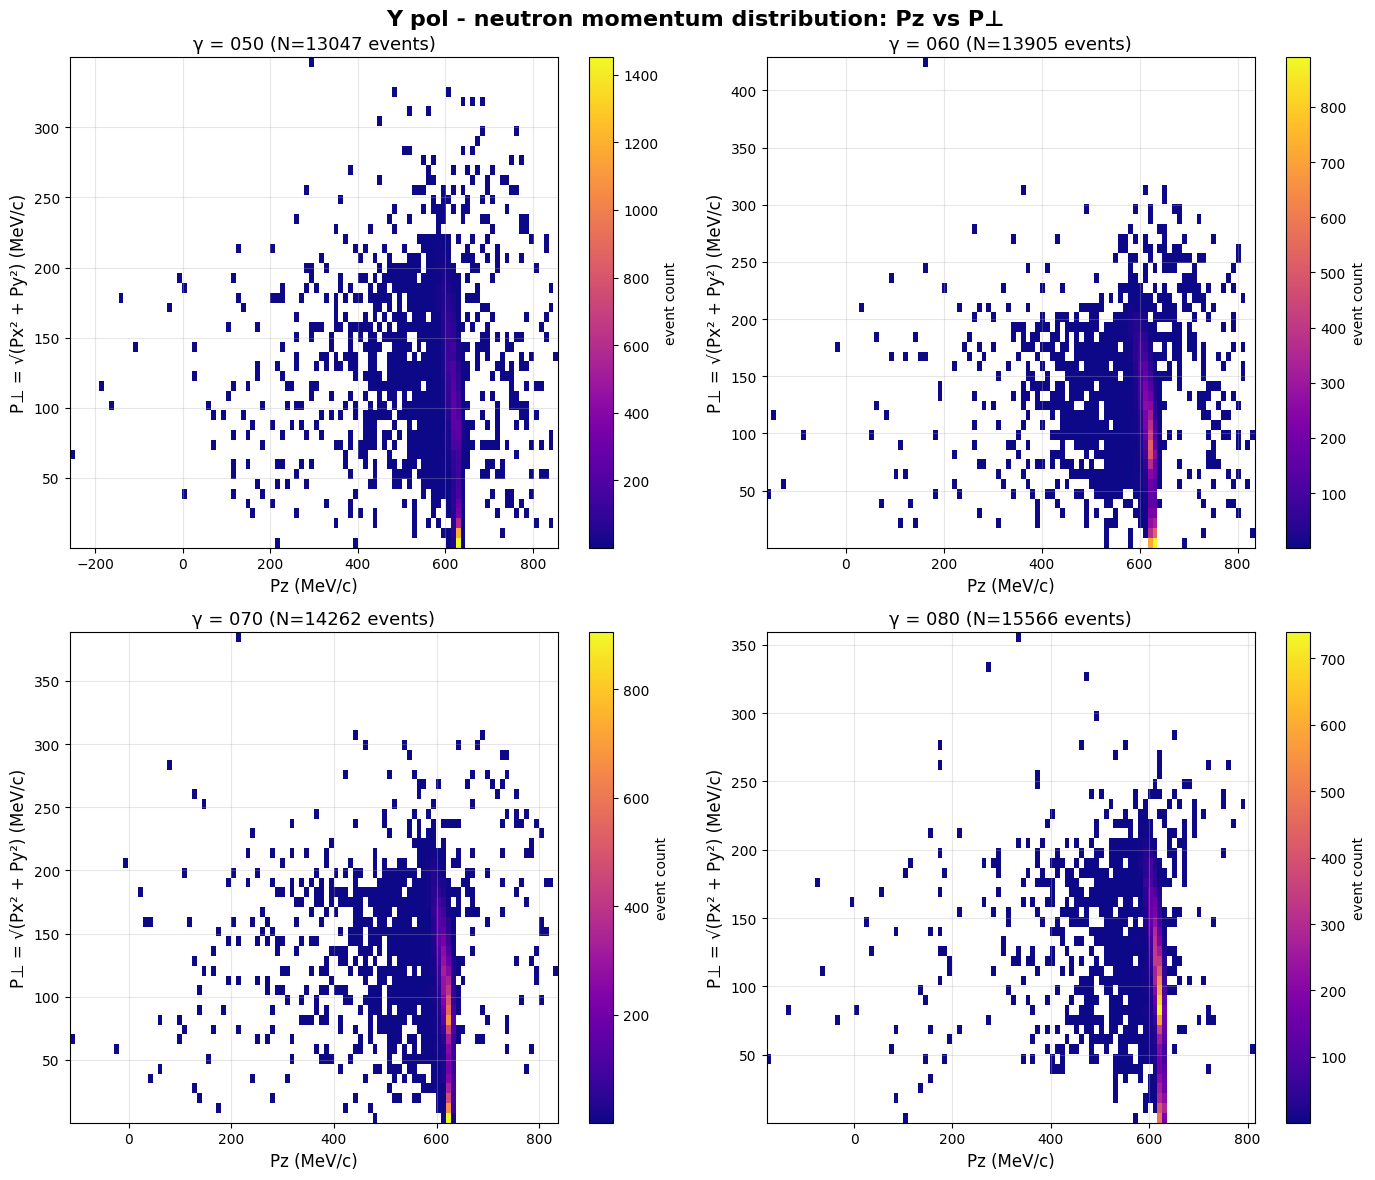


Y pol - neutron momentum statistics:

γ=050:
  Pz: mean=612.7, std=52.2, range=[-259.1, 858.5]
  P⊥: mean=80.3, std=59.1, range=[0.1, 350.0]

γ=060:
  Pz: mean=613.5, std=44.5, range=[-161.8, 835.9]
  P⊥: mean=86.0, std=57.1, range=[0.1, 429.0]

γ=070:
  Pz: mean=612.1, std=43.9, range=[-115.2, 837.3]
  P⊥: mean=90.5, std=52.6, range=[0.1, 388.5]

γ=080:
  Pz: mean=612.6, std=39.6, range=[-178.0, 815.6]
  P⊥: mean=94.1, std=50.4, range=[0.3, 359.0]


In [23]:
# Y极化数据：中子的 Pz vs P⊥ 二维直方图
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Y pol - neutron momentum distribution: Pz vs P⊥', fontsize=16, fontweight='bold')

for idx, gamma in enumerate(gammas):
    ax = axes[idx // 2, idx % 2]
    
    # 计算 P⊥
    px = np.array(y_pol_data[gamma]['neutron']['px'])
    py = np.array(y_pol_data[gamma]['neutron']['py'])
    pz = np.array(y_pol_data[gamma]['neutron']['pz'])
    p_perp = np.sqrt(px**2 + py**2)
    
    # 绘制二维直方图
    h = ax.hist2d(pz, p_perp, bins=[100, 50], cmap='plasma', cmin=1)
    plt.colorbar(h[3], ax=ax, label='event count')
    
    ax.set_xlabel('Pz (MeV/c)', fontsize=12)
    ax.set_ylabel('P⊥ = √(Px² + Py²) (MeV/c)', fontsize=12)
    ax.set_title(f'γ = {gamma} (N={len(pz)} events)', fontsize=13)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印统计信息
print("\nY pol - neutron momentum statistics:")
for gamma in gammas:
    pz = np.array(y_pol_data[gamma]['neutron']['pz'])
    px = np.array(y_pol_data[gamma]['neutron']['px'])
    py = np.array(y_pol_data[gamma]['neutron']['py'])
    p_perp = np.sqrt(px**2 + py**2)
    
    print(f"\nγ={gamma}:")
    print(f"  Pz: mean={np.mean(pz):.1f}, std={np.std(pz):.1f}, range=[{np.min(pz):.1f}, {np.max(pz):.1f}]")
    print(f"  P⊥: mean={np.mean(p_perp):.1f}, std={np.std(p_perp):.1f}, range=[{np.min(p_perp):.1f}, {np.max(p_perp):.1f}]")

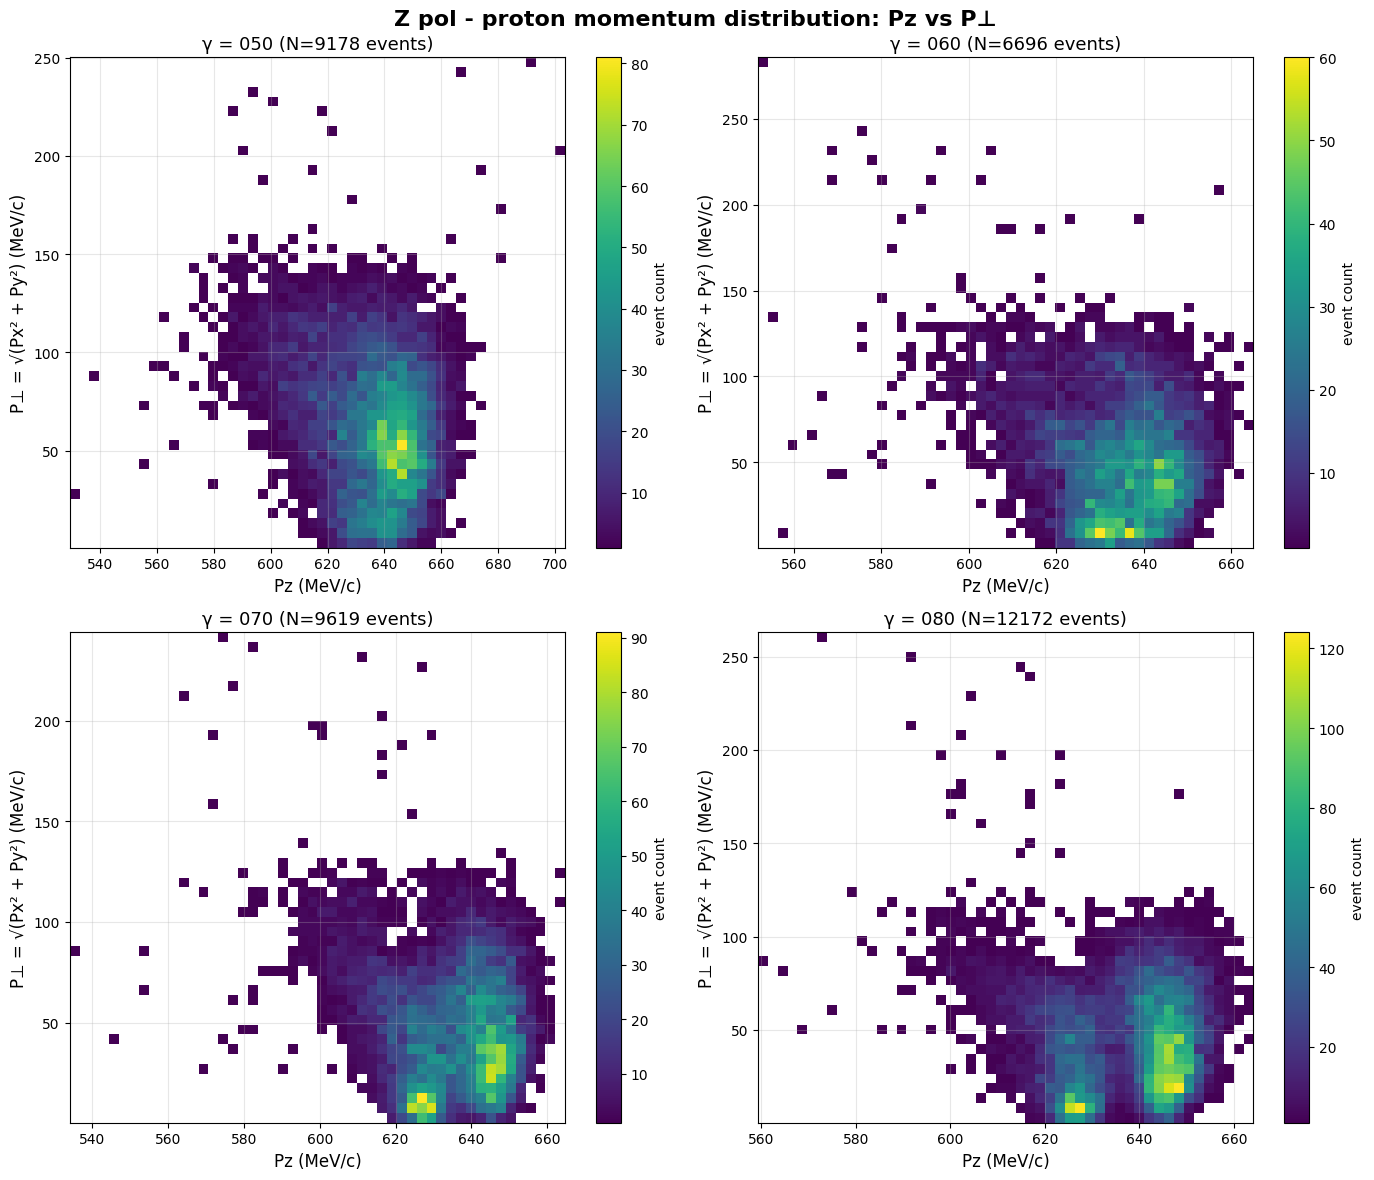


Z pol - proton momentum statistics:

γ=050:
  Pz: mean=636.1, std=15.6, range=[529.3, 703.6]
  P⊥: mean=62.7, std=32.8, range=[0.6, 250.2]

γ=060:
  Pz: mean=634.0, std=12.6, range=[551.7, 665.1]
  P⊥: mean=51.7, std=32.8, range=[0.3, 285.8]

γ=070:
  Pz: mean=634.9, std=13.0, range=[534.0, 664.8]
  P⊥: mean=45.7, std=28.0, range=[0.3, 243.8]

γ=080:
  Pz: mean=637.6, std=12.1, range=[559.3, 664.1]
  P⊥: mean=44.0, std=26.0, range=[0.3, 263.0]


In [11]:
# Z极化数据：质子的 Pz vs P⊥ 二维直方图
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Z pol - proton momentum distribution: Pz vs P⊥', fontsize=16, fontweight='bold')

for idx, gamma in enumerate(gammas):
    ax = axes[idx // 2, idx % 2]
    
    # 计算 P⊥
    px = np.array(z_pol_data[gamma]['proton']['px'])
    py = np.array(z_pol_data[gamma]['proton']['py'])
    pz = np.array(z_pol_data[gamma]['proton']['pz'])
    p_perp = np.sqrt(px**2 + py**2)
    
    # 绘制二维直方图
    h = ax.hist2d(pz, p_perp, bins=[100, 50], cmap='viridis', cmin=1)
    plt.colorbar(h[3], ax=ax, label='event count')
    
    ax.set_xlabel('Pz (MeV/c)', fontsize=12)
    ax.set_ylabel('P⊥ = √(Px² + Py²) (MeV/c)', fontsize=12)
    ax.set_title(f'γ = {gamma} (N={len(pz)} events)', fontsize=13)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印统计信息
print("\nZ pol - proton momentum statistics:")
for gamma in gammas:
    pz = np.array(z_pol_data[gamma]['proton']['pz'])
    px = np.array(z_pol_data[gamma]['proton']['px'])
    py = np.array(z_pol_data[gamma]['proton']['py'])
    p_perp = np.sqrt(px**2 + py**2)
    
    print(f"\nγ={gamma}:")
    print(f"  Pz: mean={np.mean(pz):.1f}, std={np.std(pz):.1f}, range=[{np.min(pz):.1f}, {np.max(pz):.1f}]")
    print(f"  P⊥: mean={np.mean(p_perp):.1f}, std={np.std(p_perp):.1f}, range=[{np.min(p_perp):.1f}, {np.max(p_perp):.1f}]")

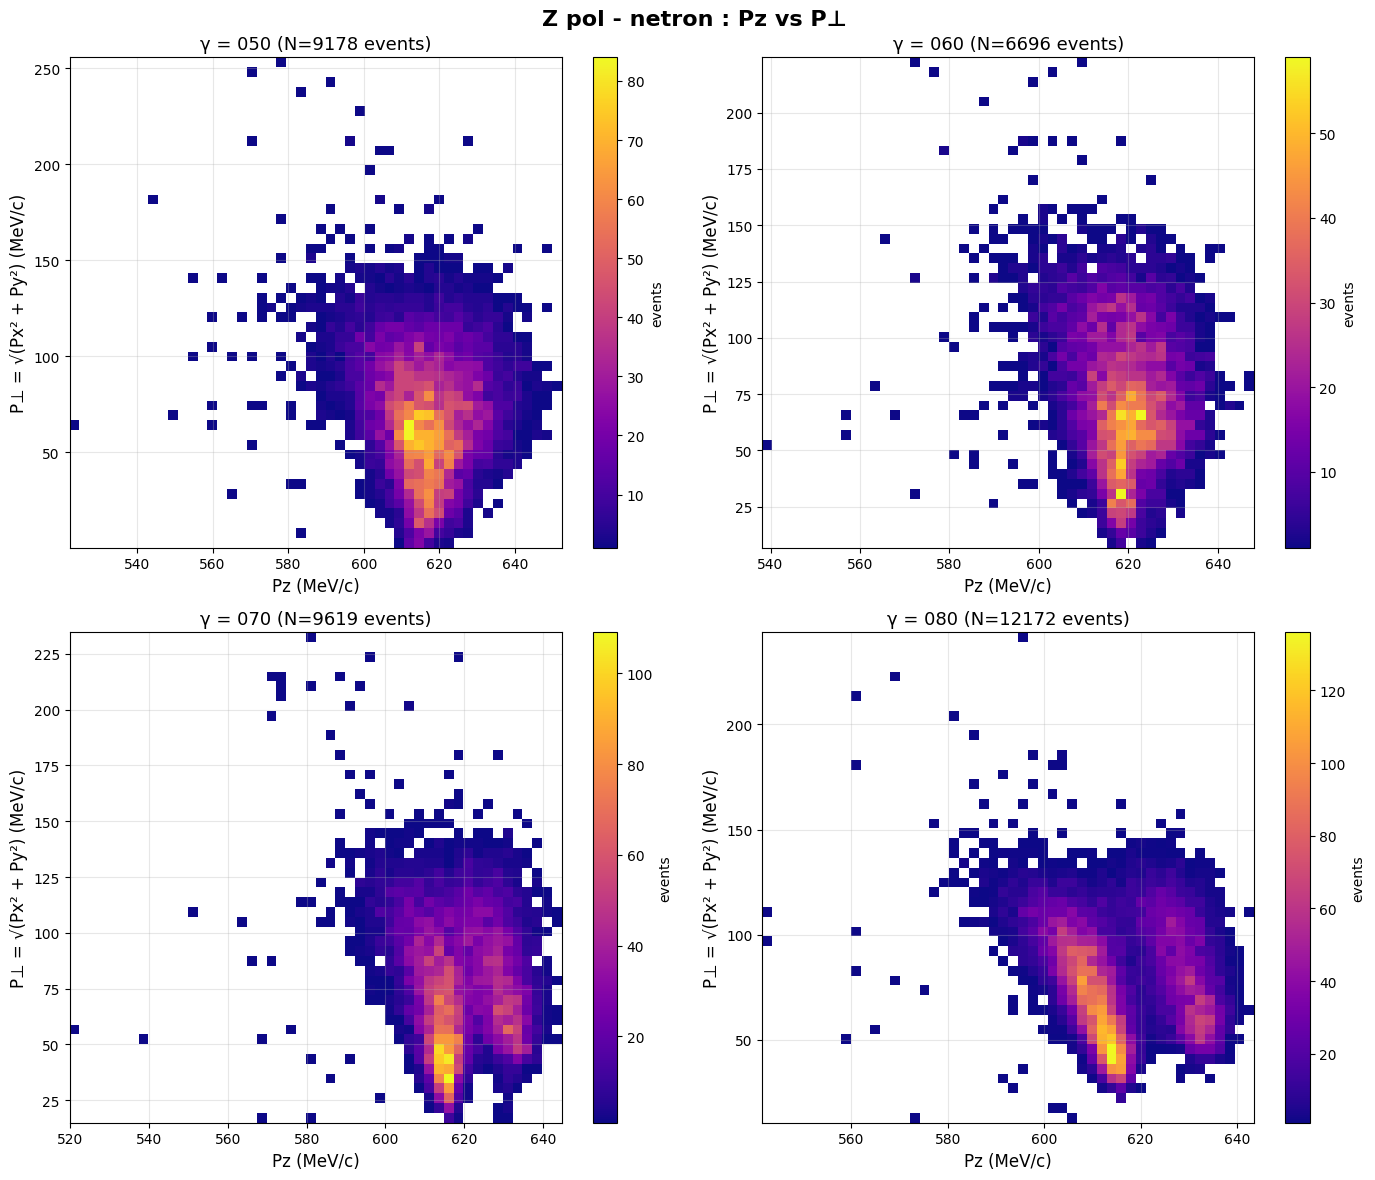


Z pol - neutron momentum statistics:

γ=050:
  Pz: mean=616.6, std=10.3, range=[522.2, 652.4]
  P⊥: mean=69.4, std=30.9, range=[0.4, 255.6]

γ=060:
  Pz: mean=619.2, std=8.6, range=[538.1, 648.1]
  P⊥: mean=74.5, std=30.1, range=[6.8, 224.5]

γ=070:
  Pz: mean=618.8, std=9.8, range=[519.8, 644.8]
  P⊥: mean=75.7, std=27.5, range=[14.9, 234.7]

γ=080:
  Pz: mean=616.0, std=11.0, range=[541.5, 643.6]
  P⊥: mean=78.0, std=25.4, range=[10.6, 243.8]


In [12]:
# Z极化数据：中子的 Pz vs P⊥ 二维直方图
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Z pol - netron : Pz vs P⊥', fontsize=16, fontweight='bold')

for idx, gamma in enumerate(gammas):
    ax = axes[idx // 2, idx % 2]
    
    # 计算 P⊥
    px = np.array(z_pol_data[gamma]['neutron']['px'])
    py = np.array(z_pol_data[gamma]['neutron']['py'])
    pz = np.array(z_pol_data[gamma]['neutron']['pz'])
    p_perp = np.sqrt(px**2 + py**2)
    
    # 绘制二维直方图
    h = ax.hist2d(pz, p_perp, bins=[100, 50], cmap='plasma', cmin=1)
    plt.colorbar(h[3], ax=ax, label='events')
    
    ax.set_xlabel('Pz (MeV/c)', fontsize=12)
    ax.set_ylabel('P⊥ = √(Px² + Py²) (MeV/c)', fontsize=12)
    ax.set_title(f'γ = {gamma} (N={len(pz)} events)', fontsize=13)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 打印统计信息
print("\nZ pol - neutron momentum statistics:")
for gamma in gammas:
    pz = np.array(z_pol_data[gamma]['neutron']['pz'])
    px = np.array(z_pol_data[gamma]['neutron']['px'])
    py = np.array(z_pol_data[gamma]['neutron']['py'])
    p_perp = np.sqrt(px**2 + py**2)
    
    print(f"\nγ={gamma}:")
    print(f"  Pz: mean={np.mean(pz):.1f}, std={np.std(pz):.1f}, range=[{np.min(pz):.1f}, {np.max(pz):.1f}]")
    print(f"  P⊥: mean={np.mean(p_perp):.1f}, std={np.std(p_perp):.1f}, range=[{np.min(p_perp):.1f}, {np.max(p_perp):.1f}]")

画出上述cut下， Pxp-Pxn的直方图。 不同配置用不同的label

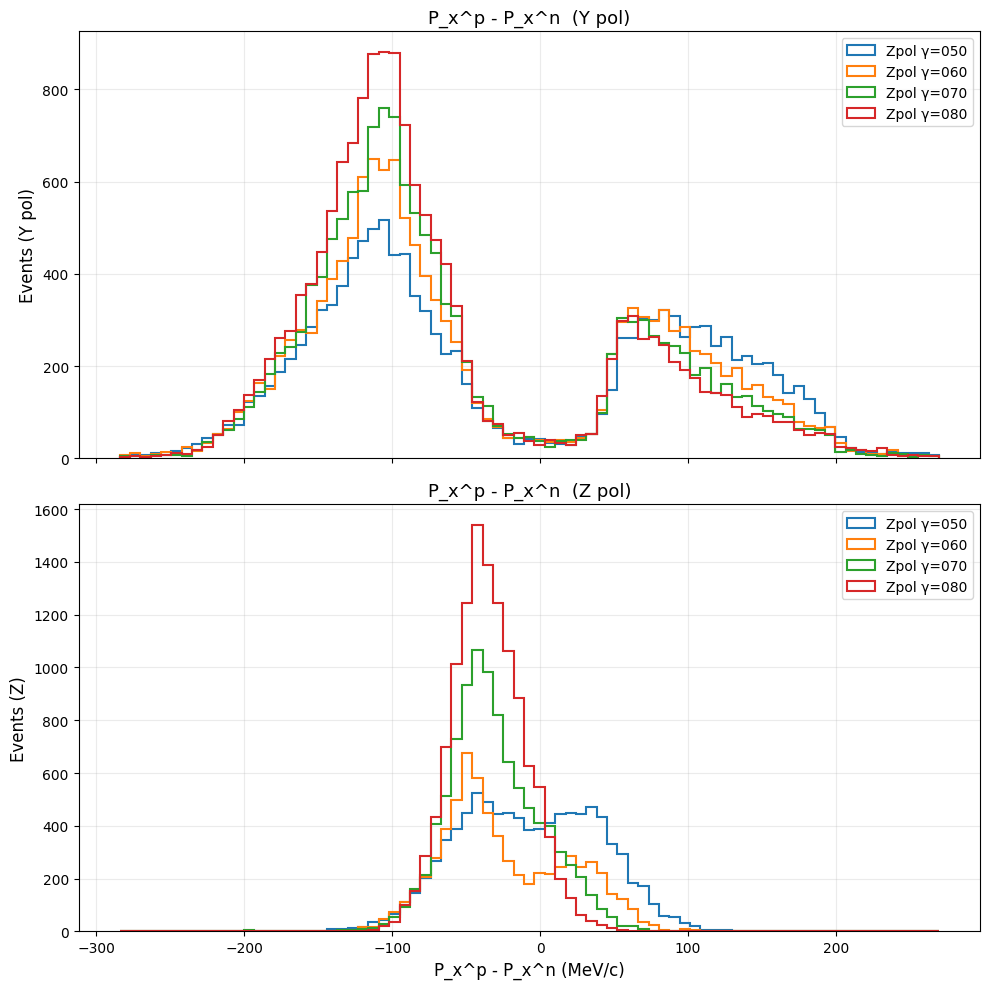

In [20]:
# 绘制 Pxp - Pxn：Y（上）/ Z（下）两张图垂直堆叠
import numpy as np
import matplotlib.pyplot as plt

# 确认数据存在
try:
    y_pol_data
    z_pol_data
    gammas
except NameError as e:
    raise RuntimeError("请先运行前面收集数据的 cell，确保 y_pol_data, z_pol_data, gammas 已生成") from e

# 计算所有差值以确定全局范围
all_diffs = []
for gamma in gammas:
    pxp_y = np.array(y_pol_data[gamma]['proton']['px'])
    pxn_y = np.array(y_pol_data[gamma]['neutron']['px'])
    if pxp_y.size and pxn_y.size:
        n = min(pxp_y.size, pxn_y.size)
        if n > 0:
            all_diffs.append(pxp_y[:n] - pxn_y[:n])
    pxp_z = np.array(z_pol_data[gamma]['proton']['px'])
    pxn_z = np.array(z_pol_data[gamma]['neutron']['px'])
    if pxp_z.size and pxn_z.size:
        n = min(pxp_z.size, pxn_z.size)
        if n > 0:
            all_diffs.append(pxp_z[:n] - pxn_z[:n])

if len(all_diffs) == 0 or np.sum([a.size for a in all_diffs]) == 0:
    raise RuntimeError("未找到任何 Pxp/Pxn 数据，请检查前面的数据收集步骤是否成功。")

# 合并以得到范围和统一 bin
concatenated = np.concatenate([a for a in all_diffs if a.size > 0])
vmin, vmax = np.percentile(concatenated, [0.5, 99.5])  # 去掉极端值
rng = vmax - vmin if (vmax - vmin) != 0 else 1.0
bins = np.linspace(vmin - 0.05*rng, vmax + 0.05*rng, 80)

# 绘图：2 行 1 列（上：Y，下：Z），共享 X 轴
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax_y, ax_z = axes
colors = ['C0', 'C1', 'C2', 'C3']
alpha_fill = 0.6

# 上：Y 极化（填充直方图）
for i, gamma in enumerate(gammas):
    color = colors[i % len(colors)]
    pxp_y = np.array(y_pol_data[gamma]['proton']['px'])
    pxn_y = np.array(y_pol_data[gamma]['neutron']['px'])
    if pxp_y.size > 0 and pxn_y.size > 0:
        n = min(pxp_y.size, pxn_y.size)
        diff_y = pxp_y[:n] - pxn_y[:n]
        ax_y.hist(diff_y, bins=bins, histtype='step', density=False,
                  color=color, linewidth=1.5, linestyle='-', label=f'Zpol γ={gamma}')

ax_y.set_ylabel('Events (Y pol)', fontsize=12)
ax_y.set_title('P_x^p - P_x^n  (Y pol)', fontsize=13)
ax_y.grid(alpha=0.25)
ax_y.legend(loc='best', fontsize=10)

# 下：Z 极化（线条直方图）
for i, gamma in enumerate(gammas):
    color = colors[i % len(colors)]
    pxp_z = np.array(z_pol_data[gamma]['proton']['px'])
    pxn_z = np.array(z_pol_data[gamma]['neutron']['px'])
    if pxp_z.size > 0 and pxn_z.size > 0:
        n = min(pxp_z.size, pxn_z.size)
        diff_z = pxp_z[:n] - pxn_z[:n]
        ax_z.hist(diff_z, bins=bins, histtype='step', density=False,
                  color=color, linewidth=1.5, linestyle='-', label=f'Zpol γ={gamma}')

ax_z.set_xlabel('P_x^p - P_x^n (MeV/c)', fontsize=12)
ax_z.set_ylabel('Events (Z)', fontsize=12)
ax_z.set_title('P_x^p - P_x^n  (Z pol)', fontsize=13)
ax_z.grid(alpha=0.25)
ax_z.legend(loc='best', fontsize=10)

plt.tight_layout()

# # 保存图片
# out_png = 'pxp_minus_pxn_YZ_stacked.png'
# plt.savefig(out_png, dpi=200)
# print(f'Plot saved to {out_png}')
plt.show()